## Calibration of wind anemometer and differential barometer

To do section
* What is the sample rate for wind and how do we regularize it to seconds proportionately?
* Match interval values
* Find linear regression
* Apply filters (that match by sample rate) and do other linear regressions
* Or apply averaging windows and linear regress
* Should we increase the sample rate for DMb on the device?




In [24]:
%matplotlib inline

from matplotlib import pyplot as plt
from flightjy import loaders, utils
import pandas as pd
import numpy as np

fname = "../logfiles/bristoldownswind.TXT"
fname = "../../logfiles/mamtorwalkwind.TXT"
fd = loaders.FlyDat(fname)
fd.LoadC("QV")


Rdatetime0 2017-03-07 15:34:57.534000 at 140.666
Rdatetime0 2017-03-07 15:34:57.532000 at 261.168
Rdatetime0 2017-03-07 15:34:57.532000 at 381.168
Rdatetime0 2017-03-07 15:34:57.527000 at 501.173
Rdatetime0 2017-03-07 15:34:57.537000 at 621.163
Rdatetime0 2017-03-07 15:34:57.534000 at 741.166
Rdatetime0 2017-03-07 15:34:57.541000 at 861.159
BAD VALUES 22 [(61, 'Qt00023FAEu035A3AA4y01E86960xFFEF7831aFFFF\n'), (61, 'Qt00024007u035A3B08y01E8694DxFFEF77D8aFFFF\n'), (61, 'Qt00024074u035A3B6Cy01E86941xFFEF7797aFFFF\n')]
Made for Q 8143 last index 8121
Made for V 8143 last index 8143


In [25]:
fd.LoadC("ZXWF")   # what are these bad values?  they look okay

BAD VALUES 7 [(0, 'Zt000015C3x0000y0000z0000a0000b0000c0000w0000x0000y0000z0000s0000\n'), (0, 'Zt000015CDx0000y0000z0000a0000b0000c0000w0000x0000y0000z0000s0100\n'), (0, 'Zt000015D7x0000y0000z0000a0000b0000c0000w0000x0000y0000z0000s0200\n')]
Made for Z 93621 last index 93614
Made for X 4750 last index 4750
Made for W 0 last index 0
Made for F 41360 last index 41360


In [26]:
fd.LoadC("FB") 
len(fd.pB), len(fd.pF)

Made for F 41360 last index 41360
Made for B 47227 last index 47227


(47227, 41360)

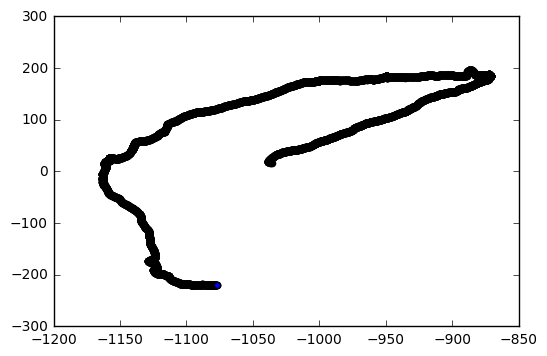

In [16]:
q = fd.pQ.iloc[100:]
plt.scatter(q.x, q.y)


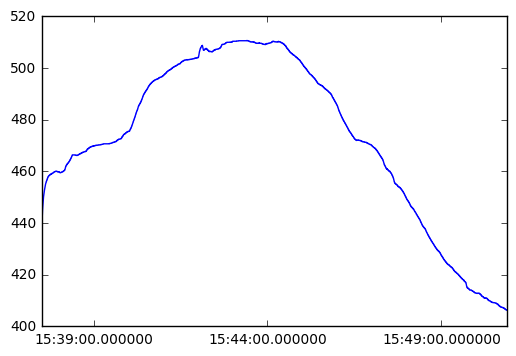

In [17]:
plt.plot(q.alt)

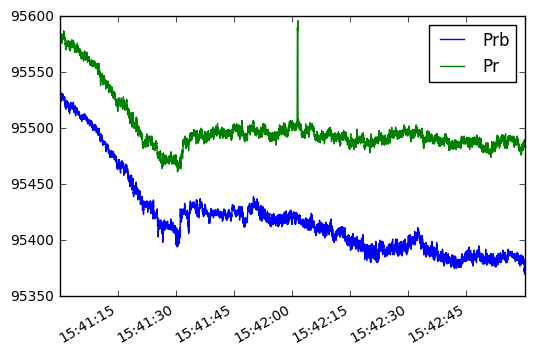

In [28]:
t0 = pd.Timestamp("2017-03-07 15:41:00")
t1 = pd.Timestamp("2017-03-07 15:43:00")
fd.pB.Prb[t0:t1].plot()
fd.pF.Pr[t0:t1].plot()
#, len(fd.pF)
plt.legend()

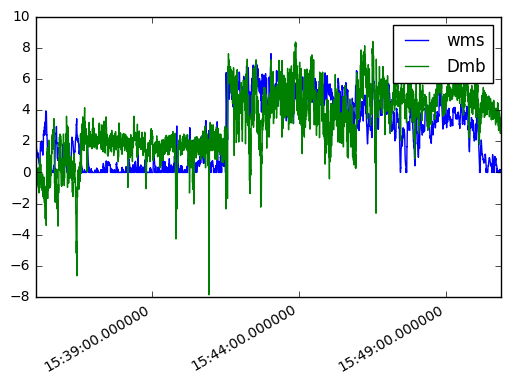

In [34]:
fd.pX.wms.plot()
((fd.pX.Dmb-50)*0.2).plot()
plt.legend()


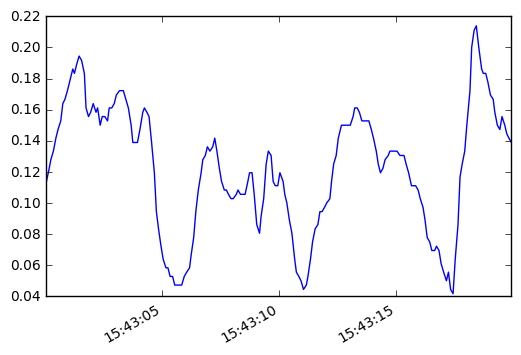

In [41]:
t0 = pd.Timestamp("2017-03-07 15:43:00")
t1 = pd.Timestamp("2017-03-07 15:43:20")
fd.pV.vel[t0:t1].plot()



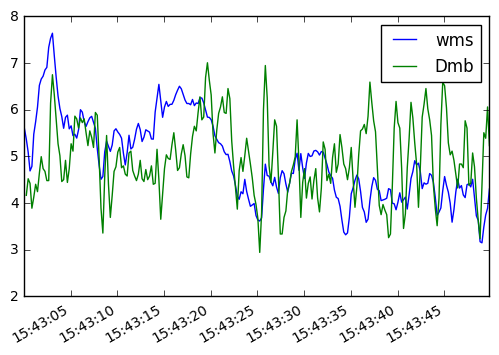

In [65]:
t0 = pd.Timestamp("2017-03-07 15:43:00")
t1 = pd.Timestamp("2017-03-07 15:43:50")
x = fd.pX[t0:t1].copy()
x.wms.plot()
k = ((x.Dmb-50)*0.1)
#k.plot()
(k+k.shift()).plot()
plt.legend()


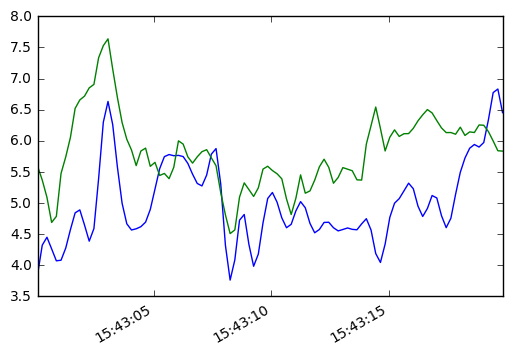

In [60]:
x["fDmb"] = (utils.FiltFiltButter(x.Dmb, 0.4)-50)*0.2

x.fDmb.plot()
x.wms.plot()


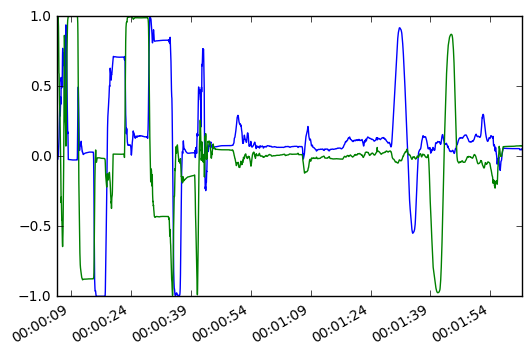

In [5]:
kZ = fd.pZ#[t0:t1].copy()
kZ["sinattack"] = utils.SinAttack(kZ)
kZ["sinroll"] = utils.SinRoll(kZ)


kZ.sinattack.plot()
kZ.sinroll.plot()
#type(utils.SinRoll(kZ))



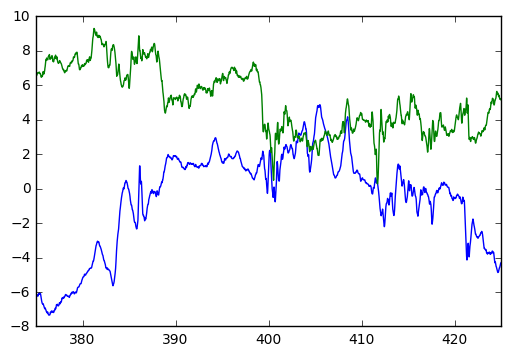

In [55]:
t0, t1 = 375, 425
kZ = fd.pZ[t0:t1]
kZ.bearing.plot()
kZ.elevation.plot()



True

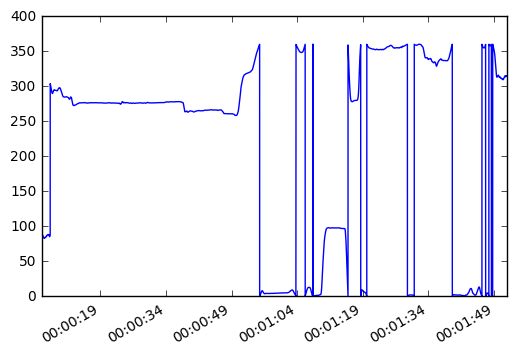

In [23]:
def NorthOrient(pZ):
    if "riqsq" not in pZ.columns:
        pZ["riqsq"] = pZ.q0**2 + pZ.q1**2 + pZ.q2**2 + pZ.q3**2 
    a00 = (pZ.q0**2 + pZ.q1**2)*2 / pZ.riqsq - 1
    a01 = (pZ.q1*pZ.q2 + pZ.q0*pZ.q3)*2  / pZ.riqsq
    return 180 - np.degrees(np.arctan2(a00, -a01))
    return rads
NorthOrient(fd.pZ).plot()

"ax" in fd.pZ.columns

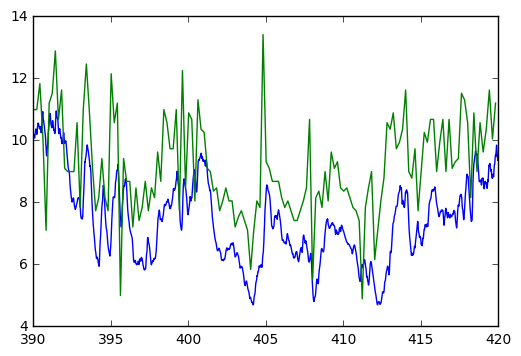

In [124]:
t0, t1 = 390, 420
kw = fd.pW[t0:t1].w
kw.plot()
kx = fd.pX[t0:t1].Dmb
(kx*0.1).plot()

kw = kw[:]
kx = kx[:]

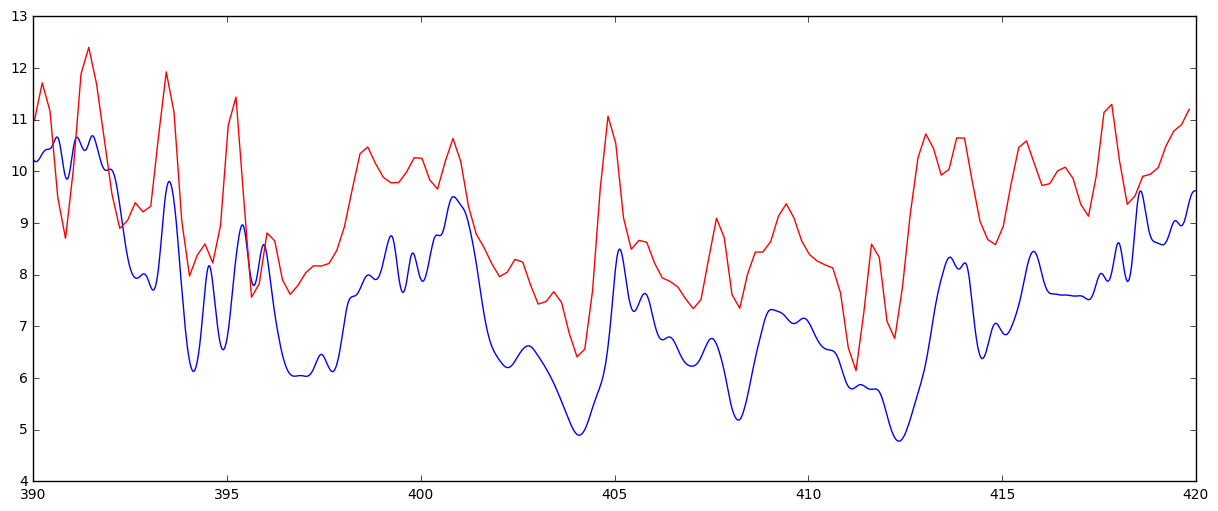

In [125]:
import scipy.signal
b, a = scipy.signal.butter(3, 0.04, 'low')
plt.figure(figsize=(15,6))
plt.plot(kw.index, scipy.signal.filtfilt(b, a, kw))
#plt.plot(kw.index, kw)

b, a = scipy.signal.butter(3, 0.5, 'low')
plt.plot(kx.index, scipy.signal.filtfilt(b, a, kx)*0.1, c="r")
#plt.plot(kx.index, kx)


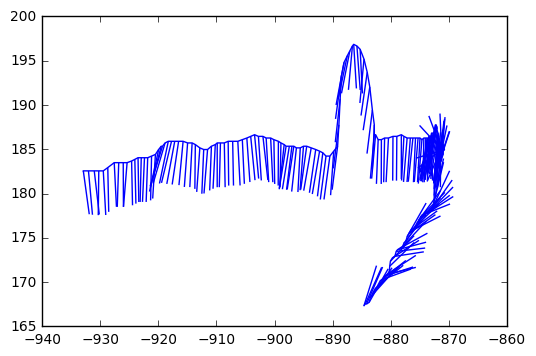

In [84]:
# try to get a proper projection and sampling if we can?
s = NorthOrient(fd.pZ)
k = fd.pQ.resample("500ms").last()[["x", "y", "alt"]].iloc[50:]
k["NN"] = s.resample("500ms").last()

k = k[200*2:300*2]
fig, ax = plt.subplots()
plt.plot(k.x, k.y)

from matplotlib import collections
import numpy, math

fac = 5
c = [ ((v.x,v.y),(v.x+math.sin(math.radians(v.NN))*fac, v.y+math.cos(math.radians(v.NN))*fac))  \
      for v in list(k.itertuples())[::1] ]
cc = collections.LineCollection(c, cmap=plt.cm.rainbow, linewidths=1)
ax.add_collection(cc)
ax.autoscale()
